In [16]:
import re
# import nltk
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter

In [17]:
# nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/tp-
[nltk_data]     home008/tbabine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Deep Learning for NLP - lab exercise 1

In this first lab exercise we will implement a simple bag-of-word classifier, i.e. a classifier that ignores the sequential structure of the sentence. The goal is to predict if a sentence is a positive or negative review of a movie. We will use a dataset constructed from IMDB.

1. Load and clean the data
2. Preprocess the data for the NN
3. Module definition
4. Train the network!

We will implement this model with Pytorch, the most popular deep learning framework for Natural Language Processing. You can use the following links for help:
* turorials: http://pytorch.org/tutorials/
* documentation: http://pytorch.org/docs/master/ 

**Hard deadline**: December 3, 2019


## Report

On top of this notebook, you must submit a report explaining your neural network, it's training method and report+analyse results, for example with different hyper-parameters (number of hidden layers, different embedding size, different hidden representation size, w or w/o dropout...you choose what you want to explore!).
You can also report results with different training dataset sizes (how does the number of training instances impact dev/test results? => *WARNING* obviously, here you change the training set size but you freeze the dev/test sets).

Training with the full dataset may be slow depending on your computer.

## Data

The data can be download here: http://teaching.caio-corro.fr/2019-2020/OPT7/imdb.zip

There are two files: one with positive reviews (imdb.pos) and one with negative reviews (imdb.neg). Each file contains 300000 reviews, one per line.


The following functions can be used to load and clean the data.

In [5]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename)
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = clean_str(f.readline()).split()
        if cleanline: 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
    print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset


The following cell load the first 5000 sentences in each review set.

In [6]:
LIM=5000
txtfile = "imdb.pos"  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)

txtfile = "imdb.neg"  # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  5000  lines from  imdb.pos  /  1  lines discarded
Load  5000  lines from  imdb.neg  /  1  lines discarded


Split the data between train / dev / test, for example by creating lists txt_train, label_train, txt_dev, ... You should take care to keep a 50/50 ratio between positive and negative instances in each set.

In [7]:
train_data = postxt[:int(len(postxt)*0.8)]+negtxt[:int(len(negtxt)*0.8)]
train_label = np.array([1.0 for i in range(int(len(train_data)/2))]+[0.0 for i in range(int(len(train_data)/2))])

dev_data =postxt[int(len(postxt)*0.8):int(len(postxt)*0.9)]+negtxt[int(len(postxt)*0.8):int(len(negtxt)*0.9)]
dev_label = np.array([1.0 for i in range(int(len(dev_data)/2))]+[0.0 for i in range(int(len(dev_data)/2))])

test_data = postxt[int(len(postxt)*0.9):]+negtxt[int(len(postxt)*0.9):]  
test_label = np.array([1.0 for i in range(int(len(test_data)/2))]+[0.0 for i in range(int(len(test_data)/2))])

# Converting data to Pytorch tensors

We will first convert data to Pytorch tensors so they can be used in a neural network.
To do that, you must first create a dictionnary that will map words to integers.
Add to the dictionnary only words that are in the training set (be sure to understand why we do that!).

Then, you can convert the data to tensors:
- use tensors of longs: both the sentence and the label will be represented as integers, not floats!
- these tensors do not require a gradient

A tensor representing a sentence is composed of the integer representation of each word, e.g. [10, 256, 3, 4].
Note that some words in the dev and test sets may not be in the dictionnary! (i.e. unknown words)
You can just skip them.

In [8]:
train_txt = ""
for s in train_data:
    for w in s:
        train_txt+= w +" "
        
token = train_txt.lower().split()
words = Counter(token)
words = sorted(words, key=words.get, reverse=True)
vocab_size = len(words)
word2idx = {o:i for i,o in enumerate(words)}
print("vocab size : ",vocab_size)

vocab size :  6997


In [106]:
word2idx

{'!': 0,
 'the': 1,
 'a': 2,
 ',': 3,
 'of': 4,
 'movie': 5,
 'and': 6,
 'this': 7,
 'to': 8,
 'it': 9,
 'i': 10,
 '\\?': 11,
 'film': 12,
 'is': 13,
 "'s": 14,
 'in': 15,
 'for': 16,
 'not': 17,
 'one': 18,
 'great': 19,
 'you': 20,
 'good': 21,
 'best': 22,
 'ever': 23,
 "n't": 24,
 'bad': 25,
 'but': 26,
 'with': 27,
 'what': 28,
 'an': 29,
 'worst': 30,
 'that': 31,
 'time': 32,
 'all': 33,
 'do': 34,
 'was': 35,
 'very': 36,
 'on': 37,
 'be': 38,
 'have': 39,
 'as': 40,
 'my': 41,
 'so': 42,
 'just': 43,
 "'": 44,
 'at': 45,
 'excellent': 46,
 'made': 47,
 'like': 48,
 'from': 49,
 'seen': 50,
 'awful': 51,
 'really': 52,
 'movies': 53,
 'no': 54,
 '\\)': 55,
 'waste': 56,
 'better': 57,
 'story': 58,
 '\\(': 59,
 'about': 60,
 'if': 61,
 'more': 62,
 'classic': 63,
 'funny': 64,
 'than': 65,
 'out': 66,
 'horror': 67,
 'see': 68,
 'love': 69,
 'your': 70,
 'fun': 71,
 "'ve": 72,
 'most': 73,
 'me': 74,
 'are': 75,
 'comedy': 76,
 'boring': 77,
 'can': 78,
 'should': 79,
 'horribl

# Neural network definition

The neural network should be defined as follows:
- it takes as input a tensor that is a sequence of integers indexing word embeddings
- it retrieves the word embeddings from an embedding table
- it constructs the "input" of the MLP by summing over all embeddingsÂ (i.e. bag-of-word model)
- it build a hidden represention using a MLP (1 layer? 2 layers? experiment! but maybe first try wihout any hidden layer...)
- it project the hidden representation to the output space: it is a binary classification task, so the output space is a scalar where a negative (resp. positive) value means the review is negative (resp. positive).

In [10]:
class CBOW_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.l1 = nn.Linear(embedding_dim, 1)
        
        nn.init.xavier_uniform_(self.l1.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.l1.bias.data)  # Xavier/Glorot init for tanh
        
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        inputs = th.sum(inputs, dim=0)
        out = F.sigmoid(self.l1(inputs))
        return out

## Loss function

Create a loss function builder.

- Pytorch loss functions are documented here: https://pytorch.org/docs/stable/nn.html#loss-functions
- In our case, we are interested in *BCELoss* and *BCEWithLogitsLoss*. Read their documentation and choose the one that fits with your network output

In [12]:
loss_fn = nn.BCELoss()
lr = 1e-1
m = CBOW_classifier(len(word2idx), 50)
train_accuracies = []
train_losses = []
dev_accuracies = []
dev_losses = []

## Training loop

Write your training loop!

- parameterizable number of epochs
- at each epoch, print the mean loss and the dev accuracy

In [13]:
def train(model, max_epochs=20):
    optim = th.optim.SGD(params=model.parameters(), lr =lr, weight_decay=1e-4)
#     model.train()
    idx_train = np.arange(len(train_data))
    idx_dev = np.arange(len(dev_data))
    
    for e in range(max_epochs):
        train_accuracy = 0
        dev_accuracy = 0
        train_mean_loss = 0
        dev_mean_loss = 0
        
        np.random.shuffle(idx_train)
        np.random.shuffle(idx_dev)
        for i in idx_train:
            s = train_data[i]
            y = train_label[i]
            
            idxsentence = th.LongTensor([word2idx[w] for w in s])
            label = th.tensor([y])
            pred = model(idxsentence)
            loss = loss_fn(pred, label)

            train_mean_loss+=loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            if((pred<0.5 and label==0) or (pred>0.5 and label == 1)):
                train_accuracy+=1
        ###Dev test
        for i in idx_dev:
            s = dev_data[i]
            y = dev_label[i]
            idxsentence = th.LongTensor([word2idx[w] for w in s if w in word2idx])
            label = th.tensor([y])
            pred = model(idxsentence)
            loss = loss_fn(pred, label)
            dev_mean_loss+=loss.item()
            if((pred<0.5 and label==0) or (pred>0.5 and label == 1)):
                dev_accuracy+=1
        train_accuracies.append(train_accuracy/len(train_data))
        train_losses.append(train_mean_loss/len(train_data))
        dev_accuracies.append(dev_accuracy/len(dev_data))
        dev_losses.append(dev_mean_loss/len(dev_data))
        print("EPOCH {}".format(e+1))
        print("Train Accuracy : ",train_accuracy/len(train_data))
        print("Dev Accuracy : ",dev_accuracy/len(dev_data))
        print("Train Mean loss : ",train_mean_loss/len(train_data))
        print("Dev Mean loss : ",dev_mean_loss/len(dev_data))
        print("----------------------------------------")

In [14]:
train(m)

C:\Users\tbabi\Anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH 1
Train Accuracy :  0.6335
Dev Accuracy :  0.655
Train Mean loss :  9.217887425070021
Dev Mean loss :  9.613918728421515
----------------------------------------
EPOCH 2
Train Accuracy :  0.710625
Dev Accuracy :  0.69
Train Mean loss :  7.894631932047601
Dev Mean loss :  8.135557932855987
----------------------------------------
EPOCH 3
Train Accuracy :  0.7315
Dev Accuracy :  0.681
Train Mean loss :  7.41177234707768
Dev Mean loss :  8.688990782208894
----------------------------------------
EPOCH 4
Train Accuracy :  0.757375
Dev Accuracy :  0.72
Train Mean loss :  6.529998884239355
Dev Mean loss :  6.82643385878489
----------------------------------------
EPOCH 5
Train Accuracy :  0.768125
Dev Accuracy :  0.729
Train Mean loss :  5.700000403839013
Dev Mean loss :  6.230844514836865
----------------------------------------
EPOCH 6
Train Accuracy :  0.782625
Dev Accuracy :  0.745
Train Mean loss :  4.418360633817906
Dev Mean loss :  5.179819380219505
-----------------------------

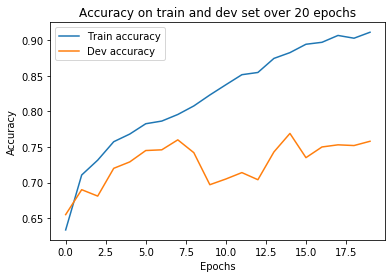

In [34]:
plt.plot(train_accuracies, label= "Train accuracy")
plt.plot(dev_accuracies, label="Dev accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy on train and dev set over 20 epochs")
plt.savefig('accuracy.png')
plt.show()

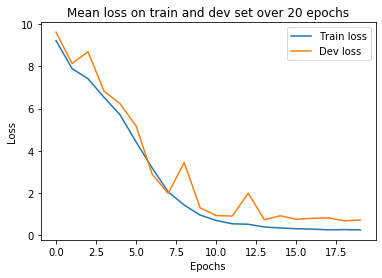

In [35]:
plt.plot(train_losses, label= "Train loss")
plt.plot(dev_losses, label="Dev loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Mean loss on train and dev set over 20 epochs")
plt.savefig('loss.png')
plt.show()